In [1]:
import importer
import tensorflow as tf
import pickle
import numpy as np
import sys
import utils
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# import pickle
with open('data.pickle', 'rb') as file_handler:
    data = pickle.load(file_handler)

In [3]:
data

{'filename': array(['1445267970.48394_2.daedalus.boiteameuh.org',
        '1423882957.56155_2.daedalus.boiteameuh.org',
        '1437951776.26567_2.daedalus.boiteameuh.org', ...,
        '1390309358.70628_1.leviathan.boiteameuh.org',
        '1390305199.53275_1.leviathan.boiteameuh.org',
        '1390337634.86743_1.leviathan.boiteameuh.org'], 
       dtype='<U69'),
 'hot-ones': array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True, False,  True, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], dtype=bool),
 'labels': array([False, False, False, ..., False, False, False], dtype=bool),
 'messageid': array(['<15080aedee2.38a2.2757308@ismtpd-075>',
        '<6e95ee8d709029b0dd088a2657ece068@async.facebook.com>',
        '<AD.2D.23363.E2765B55@rs-ord-mta07-

In [4]:
(data['labels'][:,np.newaxis]).shape

(76300, 1)

In [5]:
class SALearner:
    def __init__(self, data, learning_rate):
        # extract data
        # TODO rename filename to filenames
        self.filenames = data['filename']
        # TODO rename messageid to messageids
        self.messageids = data['messageid']
        # TODO check the names hot-ones
        self.dataset = data['hot-ones'].astype(np.float32)
        # TODO return a real column vector on importer
        self.labels = data['labels'][:,np.newaxis].astype(np.float32)
        # description variables
        self.nb_ind = data['hot-ones'].shape[0]
        self.ind_size = data['hot-ones'].shape[1]
        # Variables learned
        self.tf_weights = None
        self.tf_bias = None
        # data and labels
        self.tf_data = None
        self.tf_labels = None
        # unit result
        self.tf_z = None
        self.tf_h = None
        # Hyperparameters
        self.learning_rate = learning_rate
        # Training stats
        self.cost_data = utils.MAAcumulator(1)
        self.accuracy_data = utils.MAAcumulator(1)
        
    def init_graph(self):
        tf.reset_default_graph()
        # data
        self.tf_data = tf.placeholder(tf.float32)
        self.tf_labels = tf.placeholder(tf.float32)
        # weights and bias
        self.tf_weights = tf.Variable(tf.truncated_normal([self.ind_size, 1]))
        self.tf_bias = tf.Variable(tf.zeros([1,1]))
        # Compute the unit unit
        self.tf_z = tf.matmul(self.tf_data, self.tf_weights) + self.tf_bias #z.shape -> [ind_size,1]
        self.tf_h = tf.sigmoid(self.tf_z)
        
        #self.tf_log = -tf.log(self.tf_h)
        #self.tf_first_part = tf.multiply(self.tf_labels, -tf.log(self.tf_h))
        self.tf_regu = tf.reduce_mean(tf.multiply(self.tf_weights, self.tf_weights)) * 1e-7
        self.tf_cost_function = tf.reduce_mean(self.tf_labels * -tf.log(tf.clip_by_value(self.tf_h,1e-10, 1)) + \
                                               (1 - self.tf_labels) * -tf.log(tf.clip_by_value(1 - self.tf_h, 1e-10, 1))) + \
                                                self.tf_regu
        # accuracy & details
        tf_decision_vector = tf.round(self.tf_h)
        self.tf_correct_prediction = tf.equal(self.tf_labels, tf_decision_vector)
        self.tf_accuracy = tf.reduce_mean(tf.cast(self.tf_correct_prediction, tf.float32)) * 100
        # True positive
        self.tf_tp = tf.reduce_mean(tf.cast(tf.logical_and(tf.cast(tf_decision_vector, tf.bool),
                                                           tf.cast(self.tf_labels, tf.bool)), tf.float32)) * 100
        # True negative
        self.tf_tn = tf.reduce_mean(tf.cast(tf.logical_not(tf.logical_or(tf.cast(tf_decision_vector, tf.bool),
                                                           tf.cast(self.tf_labels, tf.bool))), tf.float32)) * 100
        # false negative
        self.tf_fn = tf.reduce_mean(tf.cast(tf.logical_and(tf.cast(tf_decision_vector, tf.bool),
                                                           tf.logical_not(tf.cast(self.tf_labels, tf.bool))),
                                            tf.float32)) * 100
        # false positive (baad)
        self.tf_fp = tf.reduce_mean(tf.cast(tf.logical_and(tf.logical_not(tf.cast(tf_decision_vector, tf.bool)),
                                                           tf.cast(self.tf_labels, tf.bool)),
                                            tf.float32)) * 100
        
        # GD
        self.tf_train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.tf_cost_function)
        
        self.tf_init = tf.global_variables_initializer()
        
    def learn(self, nb_cycle, info_every_cycle, quiet=False):
        sess = tf.Session()
        sess.run(self.tf_init)
        # reset accumulators
        self.cost_data.reset()
        self.accuracy_data.reset()
        
        for cycle in range(nb_cycle):
            _, cost, acc, z, data, labels, weights, bias, h, tp, tn, fp, fn, regu = sess.run([self.tf_train_step, self.tf_cost_function,
                                                                              self.tf_accuracy, self.tf_z, self.tf_data,
                                                                              self.tf_labels, self.tf_weights,
                                                                              self.tf_bias, self.tf_h,
                                                                              self.tf_tp, self.tf_tn,
                                                                              self.tf_fp, self.tf_fn,self.tf_regu],
                                feed_dict={self.tf_data: self.dataset,
                                           self.tf_labels: self.labels})
            # data accumulation
            self.cost_data.add(cost)
            self.accuracy_data.add(acc)
            if (cycle+1) % info_every_cycle == 0 and not quiet:
                # Console printing
                print('-' * 10)
                print('cycle: {}'.format(cycle))
                print('cost: {}'.format(cost))
                print('regu: {}'.format(regu))
                print('accuracy: {}%'.format(acc))
                print('true positive: {}%'.format(tp))
                print('true negative: {}%'.format(tn))
                print('accuracy from trues: {}%'.format(tp+tn))
                print('false positive: {}%'.format(fp))
                print('false negative: {}%'.format(fn))
                print('errors from false: {}%'.format(fp+fn))
                print('acc + err: {}%'.format(tp+tn+fp+fn))
                #print('label shape: {}'.format(labels.shape))
                #print('-log(h): {}'.format(log.shape))
                #print('fp: {}'.format(fp.shape))
                print(bias)
                print(weights[0:10,0])
                print(z[0:10,0])
                print(h[0:10,0])
                print(labels[0:10,0])
                sys.stdout.flush()
        

In [6]:
sa_learner = SALearner(data, 30)

In [7]:
sa_learner.init_graph()
sa_learner.learn(200,20,True)

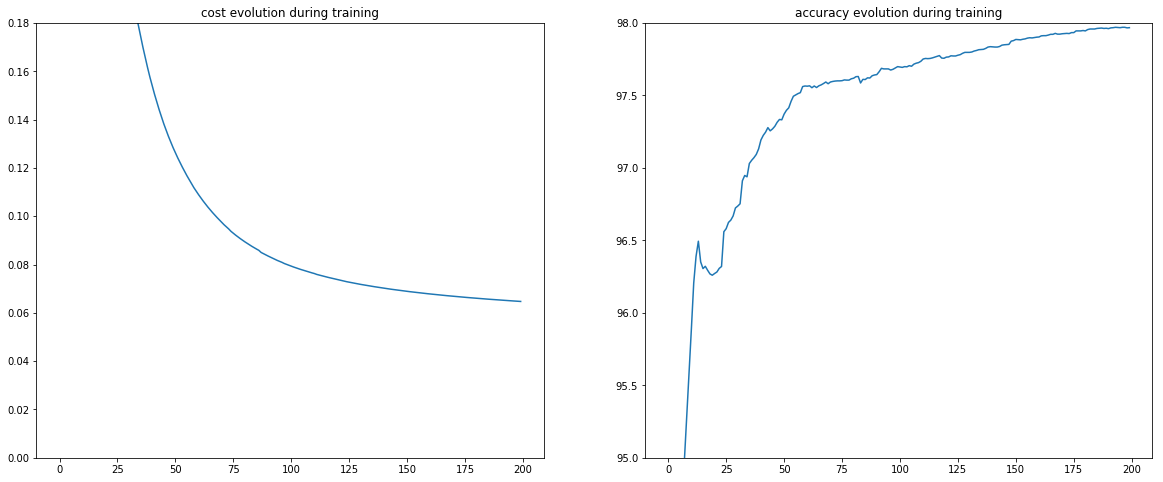

In [10]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20.0, 8.0)
f, axarr = plt.subplots(1,2)
# cost
axarr[0].plot(sa_learner.cost_data.data)
axarr[0].set_title('cost evolution during training')
axarr[0].set_ylim(0.0,0.18)
# accuracy
axarr[1].plot(sa_learner.accuracy_data.data)
axarr[1].set_title('accuracy evolution during training')
axarr[1].set_ylim(95.0,98.0)
plt.show()